# 第七次数据分析报告

Relief特征选择算法

## 1. 孙传能

### 1.1 读取数据

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score
import time
%matplotlib inline
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [5]:
header = ['gender', 'age', 'weight', 'height', 'step_len_l', 'step_max_l', 'unknown_l', 'step_speed_l', 'step_freq_l',
         'stand_time_l', 'swing_time_l', 'pre_swing_time_l', 'step_len_r', 'step_max_r', 'unknown_r', 'step_speed_r',
          'step_freq_r', 'stand_time_r', 'swing_time_r', 'pre_swing_time_r', 'period', 'double_support', 'bend1_time',
         'bend2_time']
np_df = pd.read_excel('../../第一次课/totalNPdata.xlsx', names=header, dtype=np.float32)
pd_df = pd.read_excel('../../第一次课/totalPDSdat.xlsx', names=header, dtype=np.float32)

In [6]:
%%R -i np_df -i pd_df -o df
library(dplyr)
library(lattice)
library(ggplot2)
np_df <- mutate(np_df, type=0)
pd_df <- mutate(pd_df, type=1)
df <- rbind(np_df, pd_df)

In [41]:
X = df.as_matrix()
Y = X[:, -1]
# 归一化
min_x = np.min(X[:, 1:-1], axis=0)
max_x = np.max(X[:, 1:-1], axis=0)
X[:, 1:-1] = (X[:, 1:-1] - min_x) / (max_x - min_x)
pos_x = X[np.argwhere(X[:, -1] == 1), :].squeeze()[:, :-1]
neg_x = X[np.argwhere(X[:, -1] == 0), :].squeeze()[:, :-1]
pos_arg = np.argwhere(X[:, -1] == 1).squeeze()
neg_arg = np.argwhere(X[:, -1] == 0).squeeze()
norm_x = X[:, :-1]
norm_x.shape, pos_x.shape, neg_x.shape, Y.shape, pos_arg.shape, neg_arg.shape

((384, 24), (167, 24), (217, 24), (384,), (167,), (217,))

### 1.2 实现Relief特征选择算法

#### 1.2.1 特征选择

In [48]:
# 抽样次数
n = int(np.floor(norm_x.shape[0] / 3))
# 特征权重
W = np.zeros((1, norm_x.shape[1]))
# 维护一张每个点到其他点的距离表
dist = np.zeros((norm_x.shape[0], norm_x.shape[0]))
for i in range(norm_x.shape[0]):
    for j in range(i):
        dist[i, j] = np.sum((norm_x[i, :] - norm_x[j, :])**2)
        dist[j, i] = dist[i, j]
# 开始迭代, 每次抽取一个样本取其nearHit和nearMiss
for i in range(n):
    choice = np.random.choice(norm_x.shape[0])
    nearHit, nearMiss = 9999, 9999
    nearHit_arg, nearMiss_arg = None, None
    for j in range(dist.shape[0]):
        if (dist[i, j] < nearHit) and (Y[j] == Y[choice]):
            nearHit = dist[i, j]
            nearHit_arg = j
        elif (dist[i, j] < nearMiss) and (Y[j] != Y[choice]):
            nearMiss = dist[i, j]
            nearMiss_arg = j
    W = W - (norm_x[nearHit_arg, :] - norm_x[i, :])**2 + (norm_x[nearMiss_arg, :] - norm_x[i, :])**2

#### 1.2.2 测试结果

划分7:3的训练测试比例, 使用SVM分类器. 设数据集为$X$, 上面得出了各个特征的重要程度$W$, 训练数据$X_{train} \in \Re^{n \times m}$, 其中$n$为样本总数, $m$为将要训练的特征维度  
将$W$从大到小排序, 依次从特征中抽出前1维加入训练数据做训练

In [94]:
argsorted_w = np.argsort(-W.squeeze()).squeeze()
precision = []
recall = []
f1 = []
run_time = []
for i in range(1, norm_x.shape[1]):
    X_train, X_test, Y_train, Y_test = train_test_split(norm_x[:, argsorted_w[:i]], Y.squeeze(), test_size=0.3)
    svc = SVC()
    start = time.time()
    svc.fit(X_train, Y_train)
    Y_predict = svc.predict(X_test)
    run_time.append(time.time() - start)
    precision.append(precision_score(Y_test, Y_predict))
    recall.append(recall_score(Y_test, Y_predict))
    f1.append(f1_score(Y_test, Y_predict))

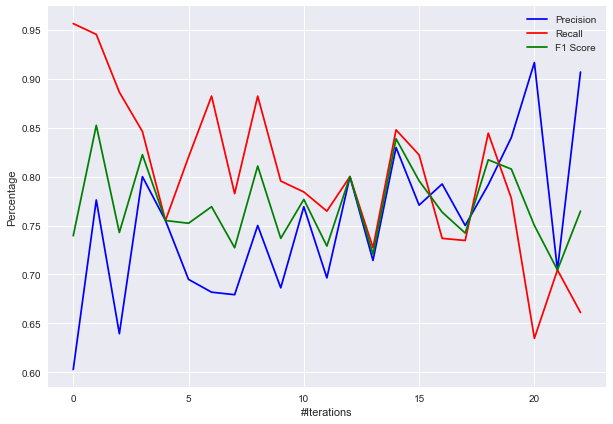

In [95]:
plt.figure(figsize=(10, 7))
plt.plot(precision, color='blue', label='Precision')
plt.plot(recall, color='red', label='Recall')
plt.plot(f1, color='green', label='F1 Score')
plt.legend()
plt.xlabel('#Iterations')
plt.ylabel('Percentage')